## Hidden Markov Model
In this section of our project we are trying to estimate the number of animal of a certain specie basing ourselves on observations of this specie. We are specifically focusing on deer but if the method reveals to be efficient, we can generalize our results to any specie.

It is important to note that by looking at counts from different years, we found that there are more data points as years go on. We have theorized that this may be due to scientists using the gbif website to record more as they may have found this site to be more useful, and also due to the fact that it has become much more easier in the past ten years to record data that it was in the nineties.

In [515]:
%matplotlib inline

# Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import *
from scipy.sparse import *
import itertools

In [738]:
# http://www.gbif.org/occurrence/search?TAXON_KEY=359&YEAR=2014#
# This is data for all Mammals in 2014 across the whole planet
mammals = pandas.read_csv('/Users/macuser/Desktop/Mammalia_US_to2015.csv', sep='\t', usecols=['year','species'], nrows=554000)


In [739]:
mammals.head()

,species,year
0,Procyon lotor,2014
1,Zalophus californianus,2014
2,Vulpes vulpes,2014
3,Odocoileus hemionus,2014
4,Lepus californicus,2014


In [740]:
deer=pd.read_csv('/Users/macuser/Desktop/Jupyter/AM207/AM207Project/Data/Deer_2015.csv', sep='\t')
deer.columns.values

array(['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'countrycode', 'locality', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'rights',
       'rightsholder', 'recordedby', 'typestatus', 'establishmentmeans',
       'lastinterpreted', 'mediatype', 'issue'], dtype=object)

## Training data Setup

In [741]:
# Create a subset data frame that just contains the columns that we need
occurences_mammals = mammals['year'].value_counts()
occurences = deer[deer.year>=1991]
occurences_deer=occurences['year'].value_counts()

In [742]:
print occurences_mammals

1994    41074
1996    36055
1992    34914
1995    32592
1993    31040
1998    28435
2002    28118
1991    27979
1999    25883
1997    24650
2001    24205
2003    23305
2000    23029
2004    22297
2005    18330
2006    16221
2014    16203
2007    15170
2009    13662
2013    12960
2015    12676
2011    12589
2010    11101
2008    11089
2012    10423
dtype: int64


In [745]:
deer_obs=[198.,168.,70.,119.,227.,104.,61.,217.,264.,71.,87.,98.,337.,121.,54.,167.,173.,84.,251.,237.,289.,543.,786.,\
          985.]
mammal_obs=[27979,34914,31040,41074,32592,36055,24650,28435,25883,23092,24205,28118,23305,22297,18330,16221,15170,\
            11089,13662,11101,12589,10423,12960,16203]

# What percentages are the deer observations out of all mammals
percentage=np.divide(deer_obs,mammal_obs)*100
percentage


array([ 0.70767361,  0.48118233,  0.22551546,  0.28972099,  0.69648994,
        0.2884482 ,  0.2474645 ,  0.76314401,  1.0199745 ,  0.30746579,
        0.35942987,  0.34853119,  1.44604162,  0.5426739 ,  0.29459902,
        1.02952962,  1.1404087 ,  0.75750744,  1.83721271,  2.1349428 ,
        2.29565494,  5.20963254,  6.06481481,  6.07912115])

As the number of deer observations increases in the past few years (since 2005, although the actual number of deer is decreasing) we normalize the data counts using the average number of mammals observation over the years.
Indeed, we assume the number of observed mammal should be the same over the years and use that ratio (average observation of mammals divided by observations on that year) as a factor to normalize the observations of deer.

In [746]:
# Normalize by the relative number of observations
average_norm=np.divide(float(np.sum(mammal_obs))/len(mammal_obs),mammal_obs)
average_norm

array([ 0.8062401 ,  0.64609588,  0.72673298,  0.5491988 ,  0.69212665,
        0.62564947,  0.91512339,  0.79331077,  0.87152925,  0.97686609,
        0.9319476 ,  0.80225449,  0.96793785,  1.01169627,  1.23064875,
        1.39065358,  1.48700011,  2.03424941,  1.65113392,  2.03205042,
        1.79186525,  2.16423215,  1.74057034,  1.39219846])

In [747]:
# Normalize the data using the observation of mammals 
norm_obs=np.multiply(average_norm,deer_obs)
norm_obs

array([  159.63553915,   108.54410838,    50.87130853,    65.35465765,
         157.11274878,    65.06754495,    55.82252705,   172.14843649,
         230.08372291,    69.35749213,    81.07944123,    78.62093973,
         326.1950565 ,   122.41524831,    66.45503273,   232.2391473 ,
         257.25101901,   170.87695013,   414.43461487,   481.59594856,
         517.84905804,  1175.17805574,  1368.0882909 ,  1371.31548427])

In [971]:
years=np.linspace(1991,2014,24)
years

array([ 1991.,  1992.,  1993.,  1994.,  1995.,  1996.,  1997.,  1998.,
        1999.,  2000.,  2001.,  2002.,  2003.,  2004.,  2005.,  2006.,
        2007.,  2008.,  2009.,  2010.,  2011.,  2012.,  2013.,  2014.])

In [749]:
## Actual estimated deer number US: http://www.deerfriendly.com/decline-of-deer-populations

In [893]:
# In Millions
actual_deer=[35.8, 36., 36., 36.2, 36.5, 36.8, 37.1, 37.4, 37.7, 38.1, 37.85, 37.5, 37.1, 36.8, 36.4, 36.1, 35.75,\
             35.4, 35., 34.6, 34.2, 33.8, 33.5, 33.2]
act_deer=np.multiply(actual_deer,10**6)

We caculate the range of ratios of observed to use in the emission probabilities.

In [894]:
ratio=np.divide(norm_obs,actual_deer)  
# This has to be divided by 10^6 but for simplicity purposes, I will keep it this way
print ratio
# Divide ratios in bins of 3
discretized_r=np.linspace(1,55,19)

discrete_ratio=np.zeros(len(actual_deer))
for i in range(len(ratio)):
    for j in range(len(discretized_r)-1):
        if ratio[i]>discretized_r[j] and ratio[i]<discretized_r[j]+0.5:
            discrete_ratio[i]=discretized_r[j]
        elif ratio[i]<discretized_r[j+1] and ratio[i]>=discretized_r[j]+0.5:
            discrete_ratio[i]=discretized_r[j+1]
        elif ratio[i]==discretized_r[j]:
            discrete_ratio[i]=discretized_r[j]
print discrete_ratio
obs_len=len(np.unique(discrete_ratio))
obs_states=(np.unique(discrete_ratio))
obs_states

[  4.45909327   3.01511412   1.4130919    1.80537728   4.30445887
   1.76813981   1.50465032   4.60289937   6.10301652   1.82040662
   2.14212526   2.09655839   8.79231958   3.32650131   1.82568771
   6.43321738   7.1958327    4.82703249  11.840989    13.91895805
  15.14178532  34.76858153  40.83845644  41.30468326]
[  4.   4.   1.   4.   4.   4.   4.   7.   7.   4.   4.   4.  10.   4.   4.
   7.   7.   7.  13.  16.  16.  37.  43.  43.]


array([  1.,   4.,   7.,  10.,  13.,  16.,  37.,  43.])

We calculate the osberved ratios by dividing the normalized observations by the average number of deer between 1991 and 2014. We therefore become able to have a vector of observed state and an emission matrix in the same format.

In [960]:
ratio=np.divide(norm_obs,np.average(actual_deer))  
# This has to be divided by 10^6 but for simplicity purposes, I will keep it this way
print ratio

train_ratio=np.zeros(len(actual_deer))
for i in range(len(ratio)):
    for j in range(len(obs_states)-1):
        if ratio[i]>obs_states[j] and ratio[i]<obs_states[j]+(obs_states[j+1]-obs_states[j])/2:
            train_ratio[i]=obs_states[j]
        elif ratio[i]<obs_states[j+1] and ratio[i]>=obs_states[j]+(obs_states[j+1]-obs_states[j])/2:
            train_ratio[i]=obs_states[j+1]
        elif ratio[i]==obs_states[j]:
            train_ratio[i]=obs_states[j]
train_ratio

[  4.43021848   3.01232493   1.4117847    1.81372778   4.36020579
   1.8057598    1.54919131   4.77747742   6.38530221   1.92481477
   2.25012325   2.18189472   9.05259176   3.39727794   1.84426548
   6.44511972   7.13925122   4.74219103  11.50142317  13.36528997
  14.37138921  32.61363707  37.96729762  38.05685895]


array([  4.,   4.,   1.,   1.,   4.,   1.,   1.,   4.,   7.,   1.,   1.,
         1.,  10.,   4.,   1.,   7.,   7.,   4.,  13.,  13.,  13.,  37.,
        37.,  37.])

In [895]:
# For discretization
discrete_states=np.linspace(30,40,41)

discrete=np.zeros(len(actual_deer))
for i in range(len(actual_deer)):
    for j in range(len(discrete_states)-1):
        if actual_deer[i]>discrete_states[j] and actual_deer[i]<discrete_states[j+1]:
            discrete[i]=discrete_states[j+1]
        elif actual_deer[i]==discrete_states[j]:
            discrete[i]=discrete_states[j]
    

In [896]:
## Deer number actual California (up to 2013 only) http://www.deerfriendly.com/deer/california

In [897]:
cali_estimated=[850000,800000,700000,670000,690000,580000,580000,580000,550000,500000,500000,680000,550000,500000,\
                     600000,405000,420000,500000,500000,490000,460000,480000,480000]

In [898]:
# Create a Dataframe with all the data
data_dict={"years": years, "Mammals_obs":mammal_obs, "Deer_obs":deer_obs, "Percentage_deer":percentage, \
           "Comparison_average":average_norm, "Actual_deer (Mi)": actual_deer, "Discretized_actual": discrete, \
          "Normalized_obs":norm_obs, "Ratio":ratio, "Discrete Ratio": discrete_ratio}
Data_summary=pd.DataFrame(data_dict)

Data_summary

,Actual_deer (Mi),Comparison_average,Deer_obs,Discrete Ratio,Discretized_actual,Mammals_obs,Normalized_obs,Percentage_deer,Ratio,years
0,35.80,0.806240,198,4,36.00,27979,159.635539,0.707674,4.459093,1991
1,36.00,0.646096,168,4,36.00,34914,108.544108,0.481182,3.015114,1992
2,36.00,0.726733,70,1,36.00,31040,50.871309,0.225515,1.413092,1993
3,36.20,0.549199,119,4,36.25,41074,65.354658,0.289721,1.805377,1994
4,36.50,0.692127,227,4,36.50,32592,157.112749,0.696490,4.304459,1995
5,36.80,0.625649,104,4,37.00,36055,65.067545,0.288448,1.768140,1996
6,37.10,0.915123,61,4,37.25,24650,55.822527,0.247465,1.504650,1997
7,37.40,0.793311,217,7,37.50,28435,172.148436,0.763144,4.602899,1998
8,37.70,0.871529,264,7,37.75,25883,230.083723,1.019975,6.103017,1999
9,38.10,0.976866,71,4,38.25,23092,69.357492,0.307466,1.820407,2000


### Test Data Setup

In [899]:
test=deer[deer.year<=1991]
test=test[test.year>=1980]
occurences_test=test['year'].value_counts()
occurences_test

1984    838
1982    609
1981    583
1986    497
1985    452
1980    430
1988    410
1990    372
1983    297
1989    260
1991    198
1987    183
dtype: int64

In [900]:
obs_test=[430,583,609,297,838,452,497,183,410,260,371,198]

In [901]:
mammals_test=pandas.read_csv('/Users/macuser/Desktop/Jupyter/AM207/AM207Project/Data/test_Mammalia.csv', sep='\t', usecols=['year','species'])

In [902]:
mam_test = mammals_test['year'].value_counts()
mam_test

1984    37560
1983    32946
1980    31507
1981    30461
1991    28080
1982    26348
1985    24824
1989    24066
1990    23260
1988    20489
1986    19633
1987    17841
dtype: int64

In [903]:
mammal_test=[31507,30461,26348,32946,37560,24824,19663,17841,20489,24066,23620]
tot_mammal=np.append(mammal_test,mammal_obs)

In [904]:
average_test=np.divide(float(np.sum(tot_mammal))/len(tot_mammal),tot_mammal)
average_test

array([ 0.75331287,  0.77918087,  0.90081329,  0.72041002,  0.63191237,
        0.9561162 ,  1.20707057,  1.33034183,  1.15840834,  0.98623072,
        1.00485303,  0.84830153,  0.67980262,  0.76464654,  0.57785043,
        0.7282348 ,  0.65828952,  0.96286526,  0.83469768,  0.91699682,
        1.02782906,  0.98056718,  0.84410799,  1.01843504,  1.06447632,
        1.29485153,  1.46320378,  1.5645767 ,  2.14037592,  1.73727335,
        2.13806221,  1.88534662,  2.27713984,  1.83137566,  1.46482926])

In [905]:
norm_test=np.multiply(average_test[0:12],obs_test)
norm_test

array([ 323.92453378,  454.26244894,  548.59529376,  213.96177641,
        529.54256504,  432.16452281,  599.91407212,  243.45255471,
        474.94742126,  256.41998789,  372.80047417,  167.96370339])

In [71]:
ratio=np.divide(norm_test,np.average(actual_deer))  
# This has to be divided by 10^6 but for simplicity purposes, I will keep it this way
print ratio

test_ratio=np.zeros(len(norm_test))
for i in range(len(ratio)):
    for j in range(len(obs_states)-1):
        if ratio[i]>obs_states[j] and ratio[i]<obs_states[j]+(obs_states[j+1]-obs_states[j])/2:
            test_ratio[i]=obs_states[j]
        elif ratio[i]<obs_states[j+1] and ratio[i]>=obs_states[j]+(obs_states[j+1]-obs_states[j])/2:
            test_ratio[i]=obs_states[j+1]
        elif ratio[i]==obs_states[j]:
            test_ratio[i]=obs_states[j]
test_ratio

[  8.98958003  12.60672846  15.22466125   5.93788464  14.69590837
  11.99346502  16.64886417   6.75631512  13.1807795    7.11618838
  10.34598911   4.66134237]


array([ 10.,  13.,  16.,   7.,  16.,  13.,  16.,   7.,  13.,   7.,  10.,
         4.])

### Transition Matrix
We calculate the transition matrix by counting the occurences of going from hidden state m to hidden state n (in other words, to go from a number m of deer in year i to a number n of dear in year i+1, and dividing the values of each row by the sum of the row: we check that the obtained probabilities on each row sum up to 1. 

In [907]:
# For the transition matrix, we create a 41 by 41 matrix and calculate the probability of a certain current letter
# knowing the previous letter. The rows of this matrix should sum up to 1 
# The columns correspond to the current letter and the rows to the previous letter

#Emission is probability from hidden to observed

#Transition is from hidden to next hidden
n=len(discrete_states)
transition=np.zeros((n,n))
# Add a pseudocount
transition=transition+0.05

for j in xrange(len(discrete)-1):
    for i in xrange(len(discrete_states)):
        if discrete[j+1]==discrete_states[i]:
            for k in xrange(len(discrete_states)):
                if discrete[j]==discrete_states[k]:
                    transition[k,i]+=1

In [908]:
SUMS=np.zeros(n)
for i in xrange(len(SUMS)):
    SUMS[i]=np.sum(transition[i,:])
    

In [909]:
transition_f=np.zeros((n,n))
for i in xrange(len(SUMS)):
    transition_f[i,:]=transition[i,:]/SUMS[i]

In [910]:
# Check to verify my calculations, the sum of the rows should be zero
SUM2=np.zeros(n)
for i in xrange(len(SUM2)):
    SUM2[i]=np.sum(transition_f[i,:])
SUM2

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

### Emission Matrix

We calculate the transition matrix by counting the occurences of going from hidden state m to observed state n (in other words, to go from a number m of deer in year i to a ratio of observed to actual of m in the same year i, and dividing the values of each row by the sum of the row: we check that the obtained probabilities on each row sum up to 1. 

In [911]:
# Emission probability
emission=np.zeros((n,obs_len))
# Add a pseudocount
emission=emission+0.05
for j in xrange(len(discrete_ratio)-1):
    for i in xrange(obs_len):
        if discrete_ratio[j]==obs_states[i]:
            for k in xrange(len(discrete_states)):
                if discrete[j]==discrete_states[k]:
                    emission[k,i]+=1

In [912]:
SUMS=np.zeros(n)
for i in xrange(len(SUMS)):
    SUMS[i]=np.sum(emission[i,:])

In [913]:
emission_f=np.zeros((n,obs_len))
for i in xrange(len(SUMS)):
    emission_f[i,:]=emission[i,:]/SUMS[i]

In [914]:
# Check to verify my calculations, the sum of the rows should be zero
SUM2=np.zeros(n)
for i in xrange(len(SUM2)):
    SUM2[i]=np.sum(emission_f[i,:])
SUM2

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [915]:
emission_log=np.log(emission_f)
transition_log=np.log(transition_f)

### Starting Probability

In [916]:
## Starting Probability
itemindex= np.where(discrete_states==discrete[0])[0][0]

starting_prob=np.zeros(n)
starting_prob[itemindex]=1
np.shape(starting_prob)

(41,)

In [917]:
discrete_ratio

array([  4.,   4.,   1.,   4.,   4.,   4.,   4.,   7.,   7.,   4.,   4.,
         4.,  10.,   4.,   4.,   7.,   7.,   7.,  13.,  16.,  16.,  37.,
        43.,  43.])

In [918]:
# The function takes as input the observed and hiddent states. 
# It takes the starting probability, the transition and emission matrix and the test data Y.

# The function returns Z, which corresponds to the array of the indexes of the corrected letter (which we can 
# extract later from the state space)

def viterbi(hidden, observed, starting_prob, Y, transition_log, emission_log):   
    size_test=len(Y)
    T1=np.zeros((len(hidden),size_test))
    T2=np.zeros((len(hidden),size_test))
    index= np.where(observed==Y[0])[0][0]
    for i in xrange(len(hidden)):
        T1[i,1]=np.log(starting_prob[i])+emission_log[i,index]
    for i in range(1,len(Y)):
        index= np.where(observed==Y[i])[0][0]
        for j in xrange(len(hidden)):
            list_val=T1[:,i-1]+transition_log[:,j]+emission_log[j,index]
            T1[j,i]=np.max(list_val) 
            T2[j,i]=np.argmax(list_val) 
    Z=np.zeros(size_test)  
    T_ind=size_test-1
    Z[T_ind]=np.argmax(T1[:,T_ind])
    
    for i in range(T_ind, 1, -1):
        Z[i-1]=T2[Z[i], i]
    
    return Z
    

In [947]:
Z=viterbi(discrete_states, obs_states, starting_prob, discrete_ratio, transition_log, emission_log)
Z

array([  0.,  24.,  24.,  25.,  26.,  28.,  29.,  30.,  31.,  33.,  32.,
        30.,  29.,  28.,  26.,  25.,  23.,  22.,  20.,  19.,  17.,  16.,
        14.,  13.])

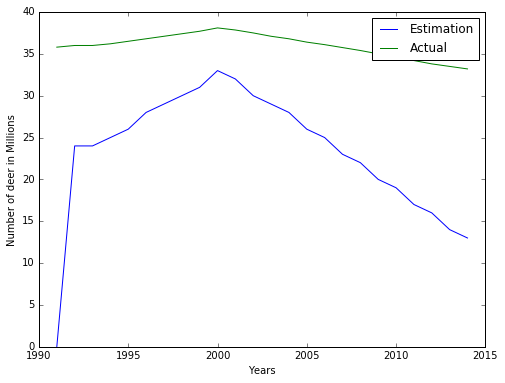

In [949]:
plt.figure(figsize=(8,6))
plt.plot(years,Z,label="Estimation")
plt.plot(years,actual_deer,label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")

In [85]:
Z2=viterbi(discrete_states, obs_states, starting_prob, train_ratio, transition_log, emission_log)
Z2

array([  0.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,
        24.,  24.,  24.,  24.,  25.,  23.,  22.,  20.,  19.,  17.,  16.,
        14.,  13.])

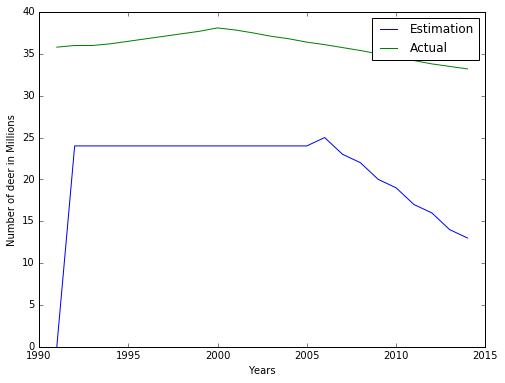

In [86]:
plt.figure(figsize=(8,6))
plt.plot(years,Z2,label="Estimation")
plt.plot(years,actual_deer,label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")

In [93]:
Z3=viterbi(discrete_states, obs_states, starting_prob2, test_ratio, transition_log, emission_log)
Z3

array([  0.,  20.,  19.,  23.,  22.,  20.,  19.,  22.,  20.,  30.,  29.,
        28.])

We can see that even though the number of observations of deer increase since 2005, Viterbi algorithm manages to translate the decrease that occured in the actual values since 2000.  While it is not close to the actual values, it did capture their trend which is interesting. However, we do not extend this algorithm to the test data as we have seen that even on the training data, the results are not accurate.

Note: We note an increase in number of deer counts after 2005. This raises the question as to whether this is reliable data. This could be due to an increase in the number of deer studies. Sightings may also depend on where the scientists decided to look for these animals, as it is unlikely there are people sweeping the entirety of the US to look for deer. Much of the data probably depends on scientific study patterns and may not reflect actual deer population. Also, it has become easier to digitally record sightings.

### Viterbi Second order

In [921]:
transition_2=np.zeros((n**2,n**2))
transition_2=transition_2+0.05

for j in xrange(len(discrete)-2):
    # Find the index of data_correct[j],[j+1],[j+2]
    for i in xrange(len(discrete_states)):
        if discrete[j+1]==discrete_states[i]:
            for m in xrange(len(discrete_states)):
                if discrete[j+2]==discrete_states[m]:
                    for k in xrange(len(discrete_states)):
                        if discrete[j]==discrete_states[k]:
                            transition_2[k*n+i,i*n+m]+=1

In [924]:
transition_f_2=transition_2/np.sum(transition_2, axis=1).reshape(n**2,1)

In [925]:
SUMS=np.zeros(n**2)
for i in xrange(len(SUMS)):
    SUMS[i]=np.sum(transition_f_2[i,:])
SUMS[1:20]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [927]:
emission_2=np.zeros((n**2,obs_len))
emission_2=emission_2+0.05

for j in xrange(len(discrete_ratio)-2):
    for i in xrange(obs_len):
        if discrete_ratio[j+1]==obs_states[i]:
            for m in xrange(obs_len):
                if discrete[j]==discrete_states[m]:
                    for k in xrange(len(discrete_states)):
                        if discrete[j+1]==discrete_states[k]:
                            emission_2[n*m+k,i]+=1
                                    
emission_f_2=emission_2/np.sum(emission_2, axis=1).reshape(n**2,1)

In [928]:
SUMS=np.zeros(27**2)
for i in xrange(len(SUMS)):
    SUMS[i]=np.sum(emission_f_2[i,:])
SUMS[1:20]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [929]:
transition_log_2=np.log(transition_f_2)
emission_log_2=np.log(emission_f_2)

In [930]:
## Starting Probability
itemindex= np.where(discrete_states==discrete[0])[0][0]
itemindex2= np.where(discrete_states==discrete[1])[0][0]

starting_prob_2=np.zeros(n*n)
starting_prob_2[itemindex*n+itemindex2]=1

In [785]:
def viterbi2(hidden, observed, starting_prob, Y, transition_log, emission_log):   
    size_test=len(Y)
    length=np.shape(transition_log)[0]
    T1=np.zeros((length,size_test))
    T2=np.zeros((length,size_test))
    ind1=np.where(observed==Y[0])[0][0]
    for i in xrange(length):
        T1[i,1]=np.log(starting_prob[i])+emission_log[i,ind1]
    for i in range(1,len(Y)-1):
        ind2= np.where(observed==Y[i])[0][0]
        for j in xrange(length):
            list_val=T1[:,i-1]+transition_log[:,j]+emission_log[j,ind2]
            T1[j,i]=np.max(list_val) 
            T2[j,i]=np.argmax(list_val) 
    Z=np.zeros(size_test)  
    T_ind=size_test-1
    Z[T_ind]=np.argmax(T1[:,T_ind])
    
    for i in range(T_ind, 1, -1):
        Z[i-1]=T2[Z[i], i]
    
    return Z

In [786]:
Z=viterbi2(discrete_states, obs_states, starting_prob, discrete_ratio, transition_log_2, emission_log_2)

In [787]:
Z

array([    0.,  1009.,  1051.,  1094.,  1177.,  1219.,  1261.,  1304.,
        1385.,  1342.,  1259.,  1217.,  1174.,  1091.,  1048.,   965.,
         922.,   839.,   796.,   713.,   670.,   587.,     0.,     0.])

This method does not seem to work properly. Need to rework it.

## Forward Backward Algorithm

Now that we have looked at decoding a sequence over the years, we use the forward–backward algorithm to find the most likely discreteized state for any point in time, in our case any year.
The algorithm involves three steps as detailed below:

1. computing forward probabilities

2. computing backward probabilities

3. computing smoothed values.

In [72]:
def FWBW(y, states, starting_prob, transition, emission, obs_states):
    L=len(y)
    fwd=[]
    f_prev={}
    
    # Forward part of the algorithm
    for i in range(L):
        f_curr = {}
        ind1=np.where(obs_states==y[i])[0][0] 
        for j in range(len(states)):
            st=states[j]
            if i == 0:
                # base case for the forward part
                prev_f_sum = starting_prob[j]
            else:
                prev_f_sum = sum(f_prev[states[k]]*transition[k,j] for k in range(len(states)))
 
            f_curr[st] = emission[j,ind1] * prev_f_sum
 
        fwd.append(f_curr)
        f_prev = f_curr
 
    bkw = []
    b_prev = {}
    # Backward part of the algorithm
    y2=np.append(y,None)
    y2=np.delete(y2,[0])
    y2=reversed(y2)
    for i, y_val in enumerate(y2):
        b_curr = {}
        for j in range(len(states)):
            st=states[j]
            if i == 0:
                # base case for backward part
                b_curr[st] = 1.0
            else:
                ind2=np.where(obs_states==y_val)[0][0] 
                b_curr[st] = sum(transition[j,l]*emission[l,ind2]*b_prev[states[l]] for l in range(len(states)))
 
        bkw.insert(0,b_curr)
        b_prev = b_curr
     
    ind3=np.where(obs_states==y[0])[0][0] 
    p_bkw = sum(starting_prob[l] * emission[l,ind3] * b_curr[states[l]] for l in range(len(states)))
 
    # Smooth the values
    posterior = []
    for i in range(L):
        posterior.append({st: fwd[i][st]*bkw[i][st]/p_bkw for st in states})
 
    return fwd, bkw, posterior

In [73]:
fwd, bkw, posterior = FWBW(discrete_ratio, discrete_states, starting_prob, transition_f, emission_f, obs_states)
print len(posterior)
print posterior

24
[{30.25: 0.0, 30.5: 0.0, 36.75: 0.0, 37.25: 0.0, 32.25: 0.0, 36.5: 0.0, 33.25: 0.0, 39.75: 0.0, 37.5: 0.0, 30.0: 0.0, 31.0: 0.0, 32.0: 0.0, 33.0: 0.0, 34.0: 0.0, 33.75: 0.0, 36.0: 0.0, 37.0: 0.0, 31.5: 0.0, 39.0: 0.0, 40.0: 0.0, 34.25: 0.0, 34.5: 0.0, 35.0: 0.0, 31.25: 0.0, 38.25: 0.0, 31.75: 0.0, 34.75: 0.0, 39.25: 0.0, 38.5: 0.0, 38.75: 0.0, 35.25: 0.0, 37.75: 0.0, 35.5: 0.0, 32.75: 0.0, 33.5: 0.0, 35.75: 1.0, 38.0: 0.0, 39.5: 0.0, 36.25: 0.0, 30.75: 0.0, 32.5: 0.0}, {30.25: 0.013346728148171116, 30.5: 0.013346728148171116, 36.75: 0.013346728148171116, 37.25: 0.032212407404137132, 32.25: 0.013346728148171116, 36.5: 0.066129861541364937, 33.25: 0.013346728148171116, 39.75: 0.013346728148171116, 37.5: 0.036539878657188656, 30.0: 0.013346728148171116, 31.0: 0.013346728148171116, 32.0: 0.013346728148171116, 33.0: 0.013346728148171116, 34.0: 0.0028816629834565104, 33.75: 0.013346728148171116, 36.0: 0.22233581917025769, 37.0: 0.070708228787064287, 31.5: 0.013346728148171116, 39.0: 0.013

This method gives the highest likelihood of each state for each consecutive year during the 24 years span. We extract the highest probability each year to plot the results.

In [74]:
results=np.zeros(len(posterior))
prob=np.zeros(len(posterior))

for i in range(len(posterior)):
    year=posterior[i]
    if i==0:
        results[i]=0
    else:
        tresh=0
        state=0
        for st in discrete_states:
            if year[st]>tresh:
                tresh=year[st]
                state=st
        results[i]=state
        prob[i]=tresh
        
print results
prob  

[  0.    36.    36.    36.    36.5   37.    36.5   37.5   37.75  38.25  38.
  37.    37.25  37.    36.5   36.25  35.75  35.5   35.    34.75  34.25  34.
  33.5   33.25]


array([ 0.        ,  0.22233582,  0.31996347,  0.27246987,  0.22232519,
        0.23832194,  0.19532792,  0.28619164,  0.34668399,  0.33113817,
        0.29210172,  0.3478593 ,  0.623926  ,  0.55984424,  0.53947474,
        0.64225071,  0.76791688,  0.86987877,  0.93164859,  0.94305426,
        0.93562055,  0.90016821,  0.76140244,  0.2999101 ])

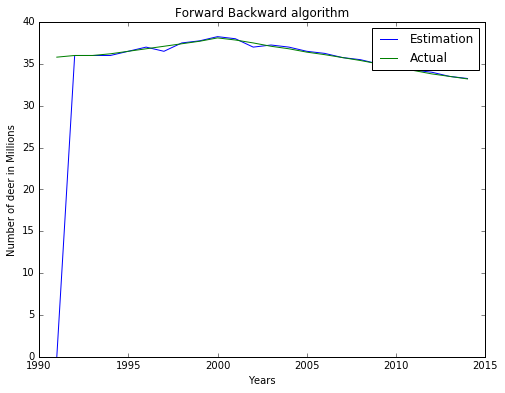

In [75]:
plt.figure(figsize=(8,6))
plt.plot(years,results,label="Estimation")
plt.plot(years,actual_deer,label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")
plt.title("Forward Backward algorithm")

The actual results and the estimation match perfectly. This is due to the fact that we have used our training data to in our model (from which we calculated transition and emission probabilities).
Therefore, we test our data on the number of deer obserevd before 1991.

### Second Option Data (average ratio)

In [950]:
fwd2, bkw2, posterior2 = FWBW(train_ratio, discrete_states, starting_prob, transition_f, emission_f, obs_states)
print len(posterior2)
print posterior2

24
[{30.25: 0.0, 30.5: 0.0, 36.75: 0.0, 37.25: 0.0, 32.25: 0.0, 36.5: 0.0, 33.25: 0.0, 39.75: 0.0, 37.5: 0.0, 30.0: 0.0, 31.0: 0.0, 32.0: 0.0, 33.0: 0.0, 34.0: 0.0, 33.75: 0.0, 36.0: 1.0, 37.0: 0.0, 31.5: 0.0, 39.0: 0.0, 40.0: 0.0, 34.25: 0.0, 34.5: 0.0, 35.0: 0.0, 31.25: 0.0, 38.25: 0.0, 31.75: 0.0, 34.75: 0.0, 39.25: 0.0, 38.5: 0.0, 38.75: 0.0, 35.25: 0.0, 37.75: 0.0, 35.5: 0.0, 32.75: 0.0, 33.5: 0.0, 35.75: 0.0, 38.0: 0.0, 39.5: 0.0, 36.25: 0.0, 30.75: 0.0, 32.5: 0.0}, {30.25: 0.00082909687710364458, 30.5: 0.00082909687710364458, 36.75: 0.00082909687710364458, 37.25: 0.0016241803608288907, 32.25: 0.00082909687710364458, 36.5: 0.0031568695367782534, 33.25: 0.00082909687710364458, 39.75: 0.00082909687710364458, 37.5: 0.0017078727360349229, 30.0: 0.00082909687710364458, 31.0: 0.00082909687710364458, 32.0: 0.00082909687710364458, 33.0: 0.00082909687710364458, 34.0: 0.00018147770553549614, 33.75: 0.00082909687710364458, 36.0: 0.92538657479856035, 37.0: 0.0031501100935674379, 31.5: 0.0008

In [951]:
results2=np.zeros(len(posterior2))
prob2=np.zeros(len(posterior2))

for i in range(len(posterior2)):
    year=posterior2[i]
    if i==0:
        results[i]=0
    else:
        tresh=0
        state=0
        for st in discrete_states:
            if year[st]>tresh:
                tresh=year[st]
                state=st
        results2[i]=state
        prob2[i]=tresh
        
print results2
prob2

[  0.    36.    36.    36.    36.    36.    36.5   37.5   37.75  38.25  38.
  37.    37.25  37.    36.5   36.25  35.75  35.5   35.    34.75  34.25  34.
  33.5   33.25]


array([ 0.        ,  0.86882869,  0.7856563 ,  0.53866697,  0.38251028,
        0.27034794,  0.19616524,  0.25412466,  0.3213163 ,  0.31504899,
        0.28071748,  0.35297515,  0.62232113,  0.55907474,  0.53912335,
        0.64212647,  0.76785667,  0.8698521 ,  0.93163949,  0.94305073,
        0.93561899,  0.90016737,  0.7614019 ,  0.29990991])

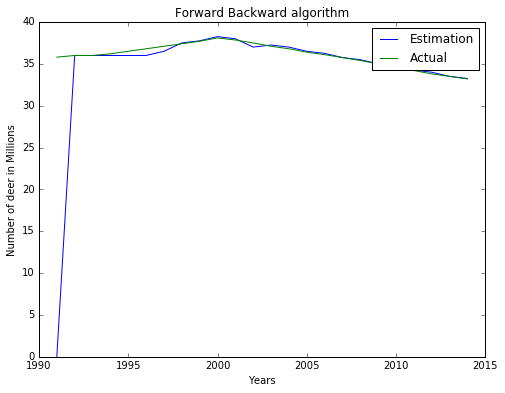

In [954]:
plt.figure(figsize=(8,6))
plt.plot(years[0:],results2[0:],label="Estimation")
plt.plot(years[0:],actual_deer[0:],label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")
plt.title("Forward Backward algorithm")

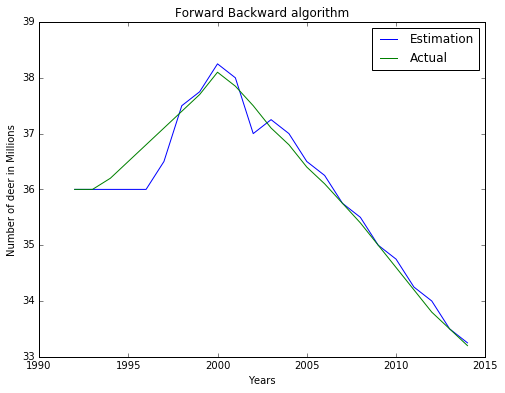

In [955]:
plt.figure(figsize=(8,6))
plt.plot(years[1:],results2[1:],label="Estimation")
plt.plot(years[1:],actual_deer[1:],label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")
plt.title("Forward Backward algorithm")

## Test Data

In [77]:
actual_deer_test=[35.75, 35, 35, 35.5, 35, 36.0, 35.5, 35.5, 35.0, 35.75, 36, 36.25]
years_test=np.linspace(1980,1991,12)

In [91]:
## Starting Probability
itemindex= np.where(discrete_states==actual_deer_test[0])[0][0]

starting_prob2=np.zeros(n)
starting_prob2[itemindex]=1
np.shape(starting_prob2)

(41,)

In [88]:
fwd3, bkw3, posterior3 = FWBW(test_ratio, discrete_states, starting_prob2, transition_f, emission_f, obs_states)
print len(posterior3)

12


In [89]:
results3=np.zeros(len(posterior3))
prob3=np.zeros(len(posterior3))

for i in range(len(posterior3)):
    year=posterior3[i]
    if i==0:
        results[i]=0
    else:
        tresh=0
        state=0
        for st in discrete_states:
            if year[st]>tresh:
                tresh=year[st]
                state=st
        results3[i]=state
        prob3[i]=tresh
        
print results3
prob3

[  0.    35.    34.75  35.75  34.25  35.    34.75  35.5   35.    37.5
  37.25  37.  ]


array([ 0.        ,  0.2950617 ,  0.29745467,  0.14375677,  0.11555702,
        0.36786858,  0.34020442,  0.26351975,  0.28878462,  0.18857527,
        0.30179647,  0.22714632])

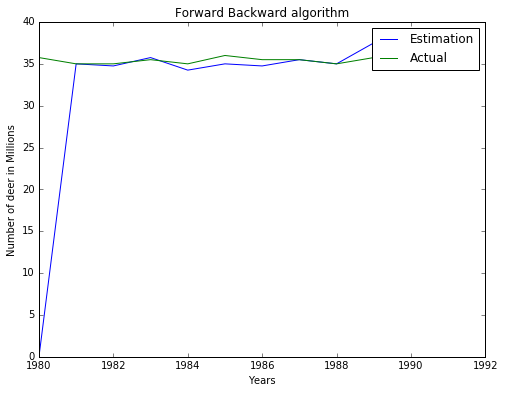

In [81]:
plt.figure(figsize=(8,6))
plt.plot(years_test,results3,label="Estimation")
plt.plot(years_test,actual_deer_test,label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")
plt.title("Forward Backward algorithm")

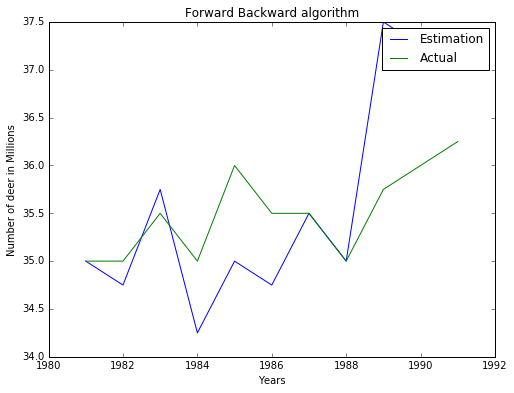

In [82]:
plt.figure(figsize=(8,6))
plt.plot(years_test[1:],results3[1:],label="Estimation")
plt.plot(years_test[1:],actual_deer_test[1:],label="Actual")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of deer in Millions")
plt.title("Forward Backward algorithm")

## Kalman Filter

In [ ]:
## Compare later with built in function

In [ ]:
from pykalman import KalmanFilter

kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [558]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P)
 
def gauss_pdf(X, M, S):
    if np.shape(M)[1] == 1:
        DX=X - np.tile(M, np.shape(X)[1])
        E=0.5 * np.sum(DX * (np.dot(inv(S), DX)), axis=0)
        E=E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P=np.exp(-E)
    elif np.shape(X)[1] == 1:
        DX=np.tile(X, np.shape(M)[1])- M
        E=0.5 * np.sum(DX * (np.dot(inv(S), DX)), axis=0)
        E=E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P=np.exp(-E)
    else:
        DX=X-M
        E=0.5 * np.dot(DX.T, np.dot(inv(S), DX))
        E=E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P=np.exp(-E)
        
    return (P[0],E[0]) 

def kf_update(X, P, Y, H, R):
    IM=np.dot(H, X)
    IS=R + np.dot(H, np.dot(P, H.T))
    K=np.dot(P, np.dot(H.T, inv(IS)))
    X=X + np.dot(K, (Y-IM))
    P=P-np.dot(K, np.dot(IS, K.T))
    LH=gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)
    


In [559]:
X =([[0.0], [0.0], [0.1], [0.1]])
np.shape(X)[0]

4

In [584]:
from numpy.linalg import *
from numpy.linalg import inv 
#time step of observations
dt = 1
# Initialization of state matrices
X = np.array(np.zeros((41,1)))
X[0]=actual_deer[0]
P = np.diag(np.zeros(41)*0.1)
A = transition_f
Q = np.eye(np.shape(X)[0])
B = emission_f
U = np.zeros((np.shape(X)[0],1)) 
 
    
# Measurement matrices
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.diag(np.zeros(41)*1)
R = np.eye(np.shape(Y)[0])
# Number of iterations in Kalman Filter
N_iter = 50
# Applying the Kalman Filter
for i in np.arange(0, N_iter):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] +\
    abs(0.1 * np.random.randn(1)[0])]])

ValueError: shapes (41,9) and (41,1) not aligned: 9 (dim 1) != 41 (dim 0)

In [585]:
# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = np.diag((0.01, 0.01, 0.01, 0.01))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0,1]])
Q = np.eye(np.shape(X)[0])
B = np.eye(np.shape(X)[0])
U = np.zeros((np.shape(X)[0],1)) 
 
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(np.shape(Y)[0])

# Number of iterations in Kalman Filter
N_iter = 50
# Applying the Kalman Filter
for i in np.arange(0, N_iter):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] +\
    abs(0.1 * np.random.randn(1)[0])]])

In [586]:
B

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [441]:
import pylab

Q = 1e-5 # process variance

n_iter=50

# intial parameters
sz=50

xhat=numpy.zeros(sz)      # a posteri estimate of x
P=numpy.zeros(sz)         # a posteri error estimate
xhatminus=numpy.zeros(sz) # a priori estimate of x
Pminus=numpy.zeros(sz)    # a priori error estimate
K=numpy.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,sz):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]


